In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
#from theanoCortexLib import kernel2connection, gkern2
import topologyLib
import scipy.ndimage.filters as fi
from time import time
%matplotlib inline

In [15]:
# Need to tune for width and intensity too
def generateMovingFFT(F, it, direction, noise=0.2, size = 15):
    x = np.random.rand(size)*noise
    #print it%14<12
    if it%14<12:
        j=int(it%12)/2
        for i in np.array(range(3))-1:
            n = min(max(F+i+direction*j, 0),size-1)
            x[n]=1-0.3*abs(i)
    return x.reshape(size,1)
def sigmoid(x,k):
    return 1 / (1 + np.exp(-x))


6 0 0


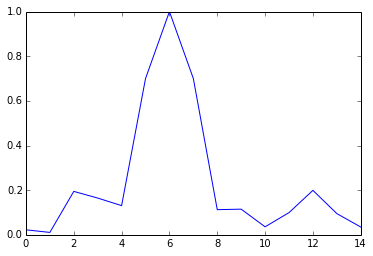

6 0 1


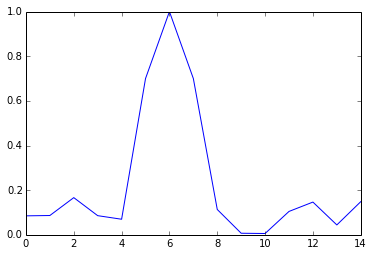

6 0 2


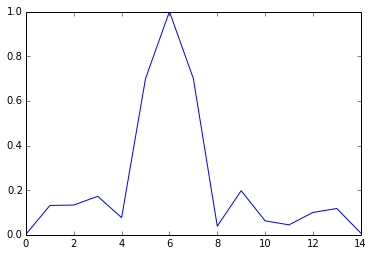

6 0 3


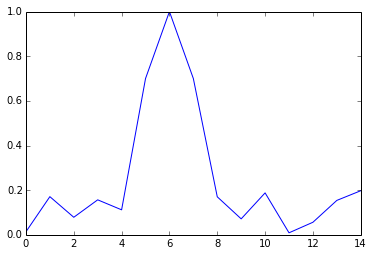

6 0 4


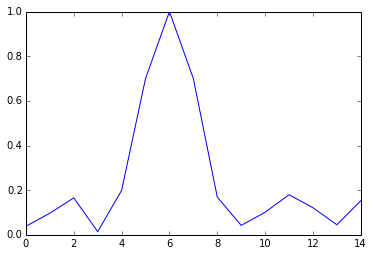

6 0 5


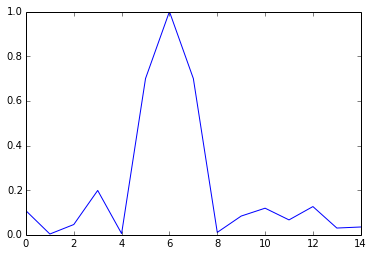

6 0 6


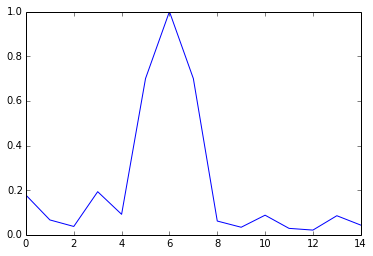

6 0 7


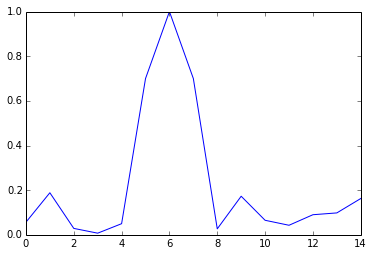

6 0 8


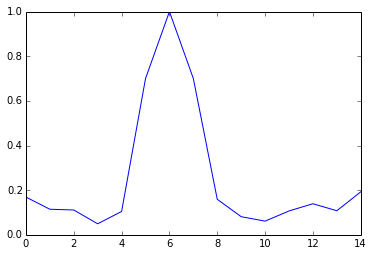

6 0 9


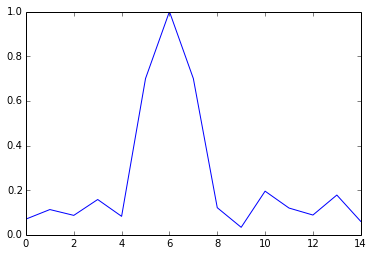

6 0 10


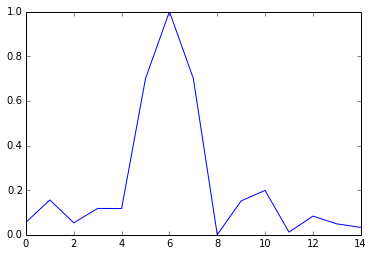

6 0 11


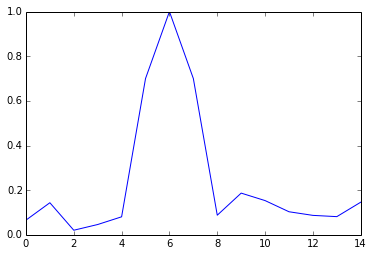

6 0 12


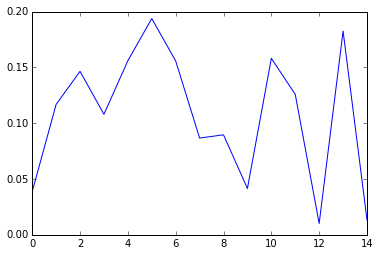

6 0 13


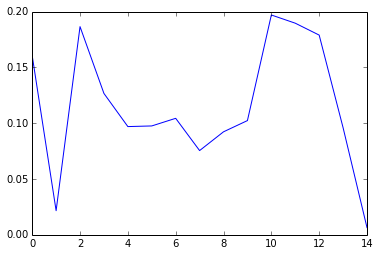

0 -1 14


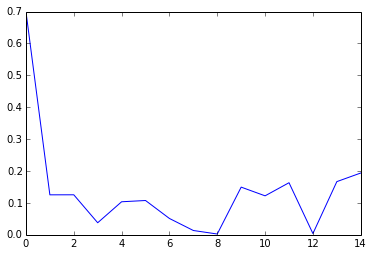

0 -1 15


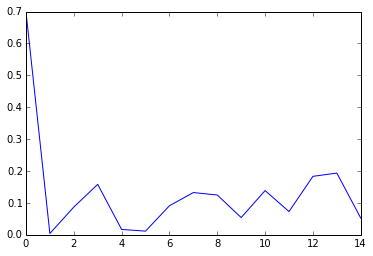

0 -1 16


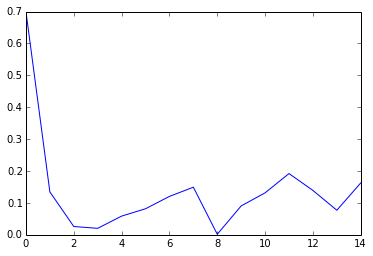

0 -1 17


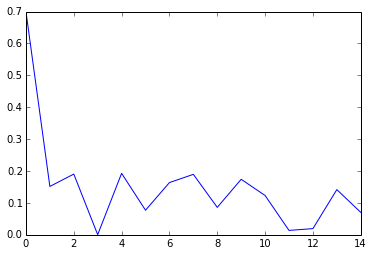

0 -1 18


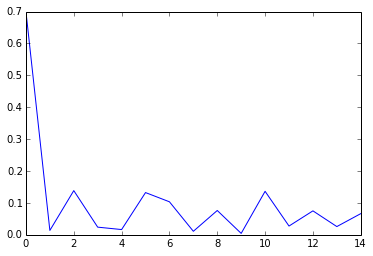

0 -1 19


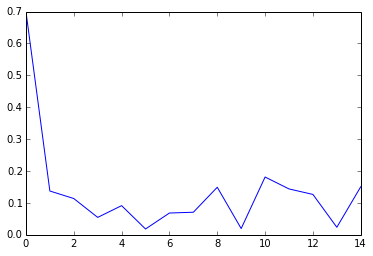

0 -1 20


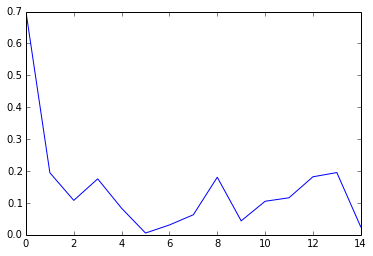

0 -1 21


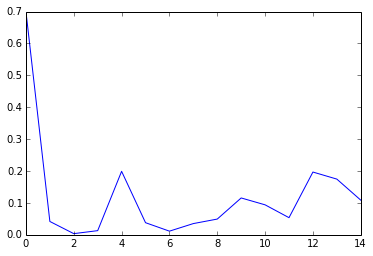

0 -1 22


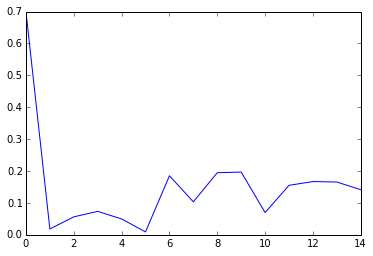

0 -1 23


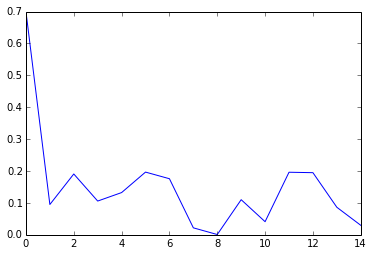

0 -1 24


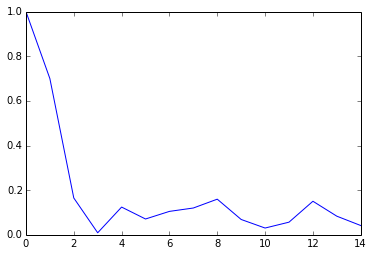

In [16]:
# Test the FFT Generation
freqs = [0,3,6,9,12,15]
dirs = [-1,0,1]
for i in range(25):
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    print F, D, i
        
    plt.plot(generateMovingFFT(F,i,D))
    plt.show()

(46, 1)


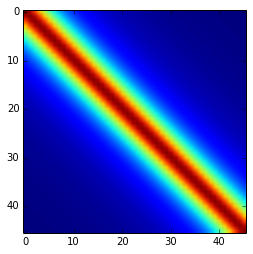

(7, 7)
Remember to always check how is the kernel!!!


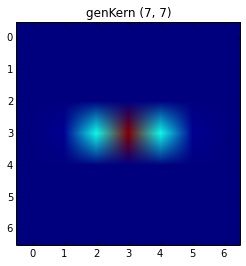

[info] Kernel shape: (7, 7)
[info] Connection Matrix shape: (15, 46)
3.5
0.5
here!!!!!


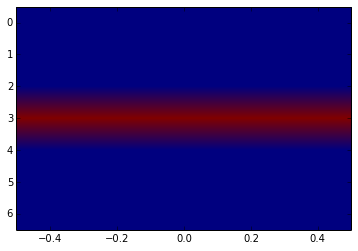

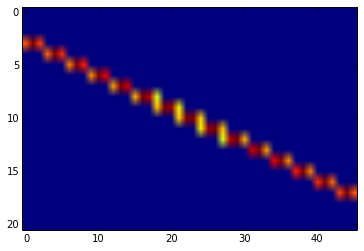

updown!!
[info] Shape was fit from (21, 46) to (15, 46)


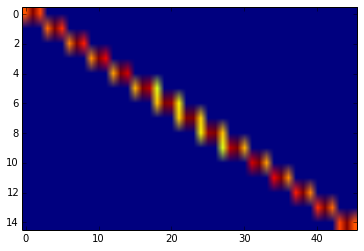

Shape = (15, 46)


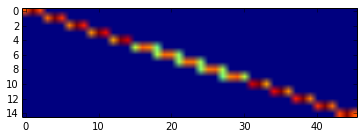

In [ ]:
# Re initialize variables: 
N=(46,1)
max_distance_x= 10. #units
max_distance_y= 1. #units
neurons = np.zeros(N)

x = np.arange(0,max_distance_x,max_distance_x/N[0]).reshape(N[0],1)*np.ones(N)
y = np.arange(0,max_distance_y,max_distance_y/N[1]).reshape(1,N[1])*np.ones(N)
x=x.reshape(N)
y=y.reshape(N)
print y.shape

connections = np.identity((neurons.size))

distances = np.zeros(connections.shape)
x = x*np.ones((x.size,x.size))
y = y*np.ones((y.size,y.size))

dx = x-x.transpose()
dy = y-y.transpose()

distances = dx**2+dy**2



dw = np.zeros(connections.shape)
dC = np.zeros(connections.shape)
k=1 #influence of distance
K=0.5  #Max probability
_distances = 1/(1+k*distances)
plt.imshow(_distances)
plt.show()
aux_kernel = np.ones((1,2*distances.shape[1]))


freqs = [0,3,6,9,12,15]
dirs = [-1,0,1]
i_shape = (15,1)
X=np.array(neurons)
inp = np.zeros(i_shape)
LR=0.001

# create nxn zeros
kern_shape=(7,7)
sigma = [3,1]
kern1 = gkern2(kern_shape,sigma)
#kern1 = np.zeros(filter_shape)
Wi = kernel2connection(kern1, i_shape, N)
#Wi /= np.sum(Wi,1).reshape((Wi.shape[0],1))*15
print 'Shape = ' + str(Wi.shape)
if np.sum(Wi,1)[0] != 1:
    Wi /= np.sum(Wi,1).reshape((Wi.shape[0],1))
plt.imshow(Wi)
c_inp = Wi

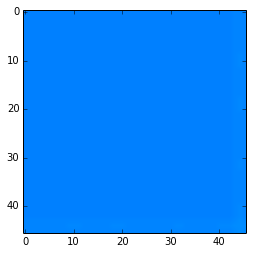

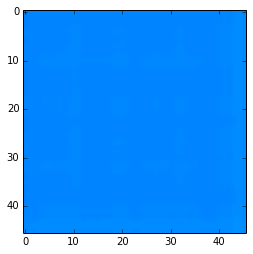

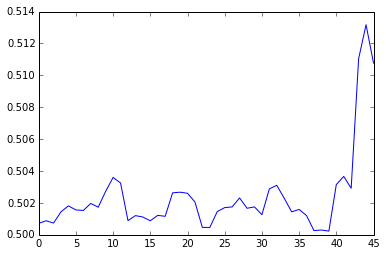

In [ ]:
# Run simulation
C=0.0000001
alpha = 0.2
a=connections
LR=0.9
asd=0
X=np.zeros(neurons.shape)
not_identity=(np.identity(X.size)==0) #Will never create connections with oneself
W_recursive = 0.00005

for i in range(1000000):
    #X = np.random.rand(N[0],N[1])
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    #Generate input
    inp = generateMovingFFT(F,i,D)
    #Compute network activity
    X=alpha*(np.dot(c_inp.T,inp) + W_recursive*np.dot(connections,X))+(1-(1+W_recursive)*alpha)*np.dot(np.identity(X.size),X)
    X=sigmoid(X,1)
    mask_C_0 = connections<=0
    
    # Compute probability of connection
    probabilities = K*np.dot(connections*_distances,_distances.transpose())*mask_C_0 # sg.convolve(K*connections*np.dot(_distances,_distances.transpose()), aux_kernel,'same')*mask_C_0.mask
    # Compute Hebbian plasticity (to weight the probability)
    dw = np.dot(X,X.transpose())-np.dot(X, np.dot(X.transpose(),C*np.ones((connections.shape[0],connections.shape[1]))) )# Oja, right now
    #Warnings!!
    if np.isnan(dw).any():
        print 'error: NAN found in dw. At iteration: ' + str(i)
        break

    # Create new dendrite if weighted probability is greater than 0.7
    new_dendrites = probabilities + dw - 0.7 #probabilities - np.random.rand(connections.shape[0],connections.shape[1])
    dC = (new_dendrites > 0)* dw
    # update
    connections = connections + (mask_C_0*dC)#+ (connections>0)*np.dot(X,X.transpose())-np.dot(X, np.dot(X.transpose(),connections) )# Oja, right now
    # Scale connections
    connections[not_identity] /= np.sum(connections[not_identity],0)
    
    # Add LR for non-diagonal, non-zero weights
    dC = np.dot(X,X.T)-np.dot(X, np.dot(X.T,connections))
    #plt.plot(X)
    #plt.show()
    dC*=not_identity
    if i%10000000 ==0:
        plt.imshow(np.dot(X,X.T),vmin=0, vmax=1)
        plt.show()
        plt.imshow(np.dot(X, np.dot(X.T,connections)),vmin=0, vmax=1)
        plt.show()
        plt.plot(X)
        plt.show()
    #connections[connections>0] += LR*(dC[connections>0])
    #connections[not_identity] /= np.sum(connections[not_identity],0)

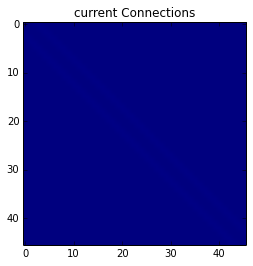

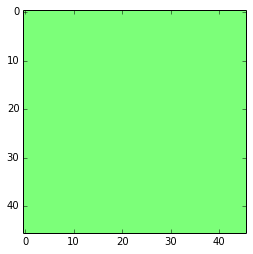

In [10]:
plt.imshow(connections*not_identity,vmin=0,vmax=1)
plt.title('current Connections')
plt.show()
plt.imshow(connections-a,vmin=-1,vmax=1)
a=connections

In [11]:
# Need to analise the data

9 1 0


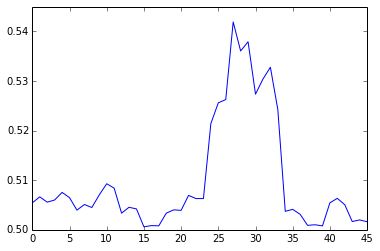

9 1 1


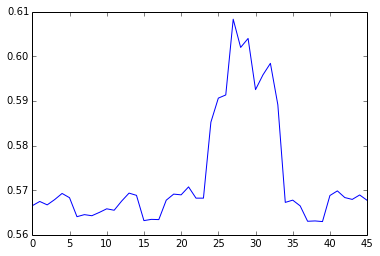

9 1 2


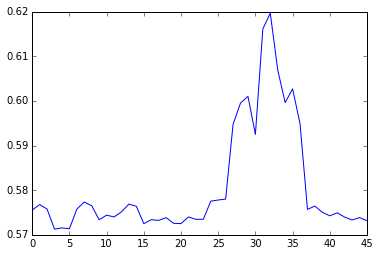

9 1 3


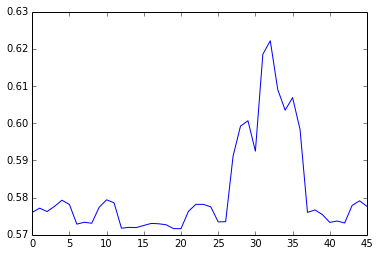

9 1 4


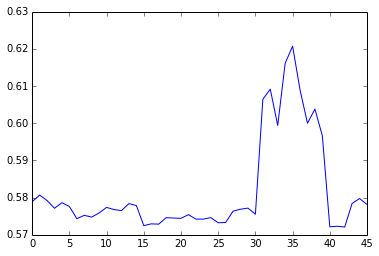

9 1 5


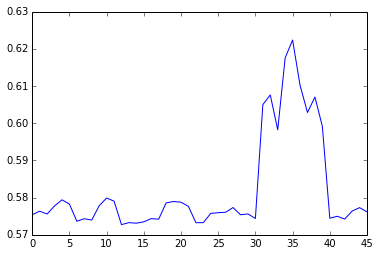

9 1 6


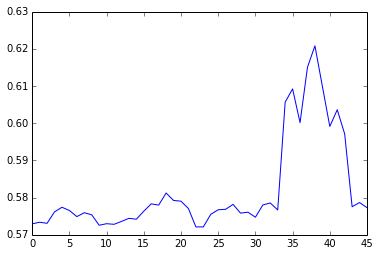

9 1 7


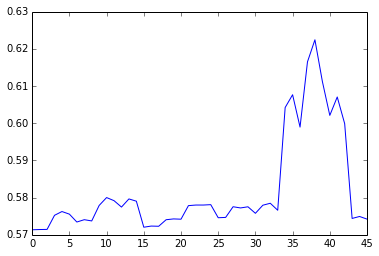

9 1 8


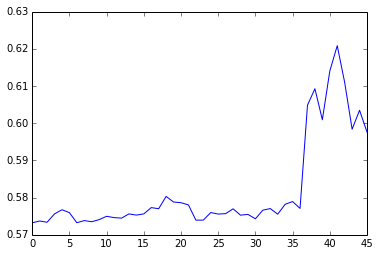

9 1 9


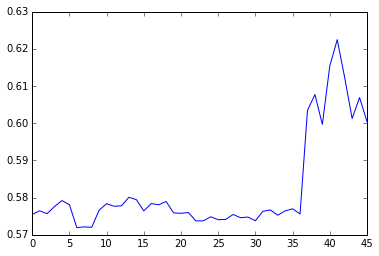

9 1 10


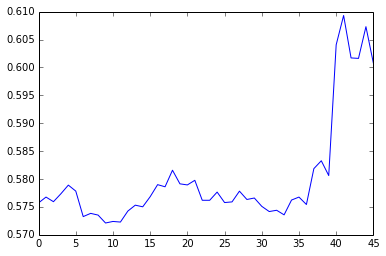

9 1 11


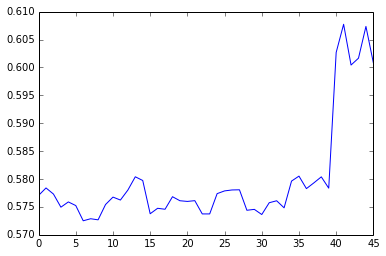

9 1 12


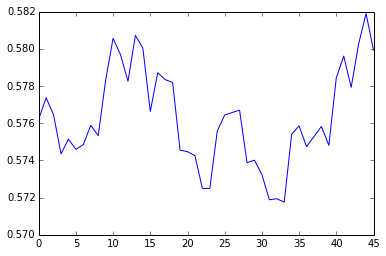

9 1 13


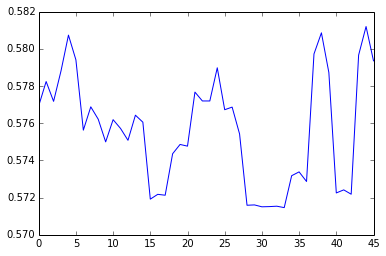

0 -1 14


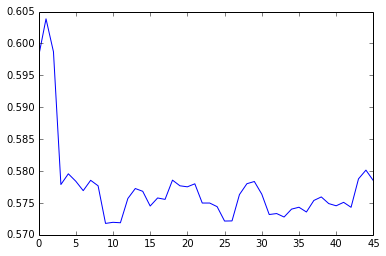

0 -1 15


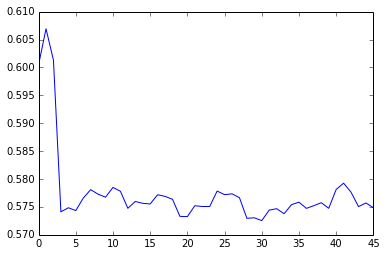

0 -1 16


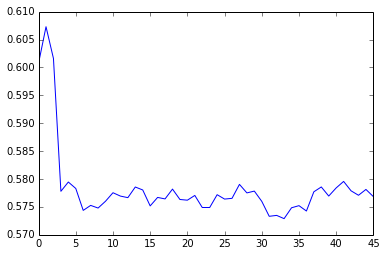

0 -1 17


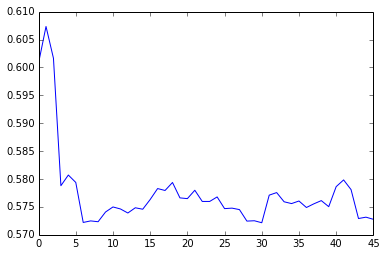

0 -1 18


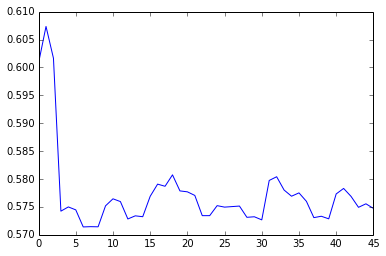

0 -1 19


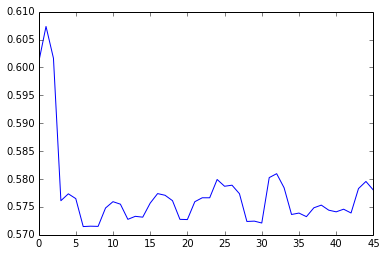

0 -1 20


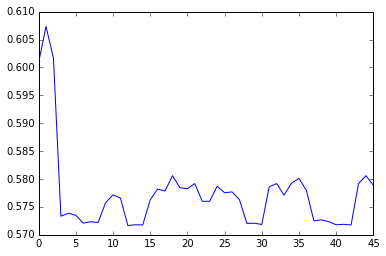

0 -1 21


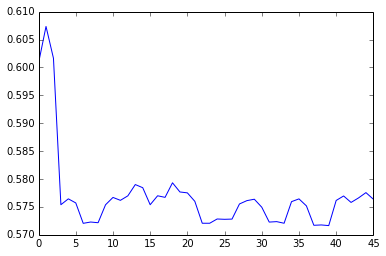

0 -1 22


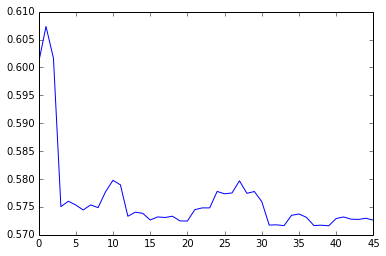

0 -1 23


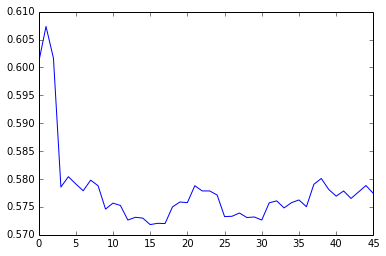

0 -1 24


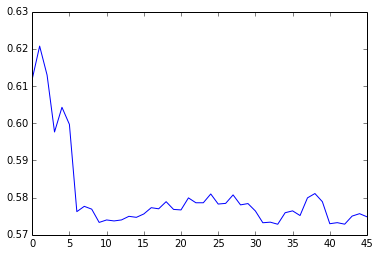

0 -1 25


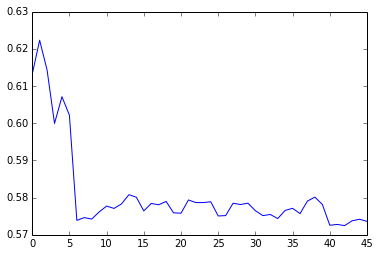

0 -1 26


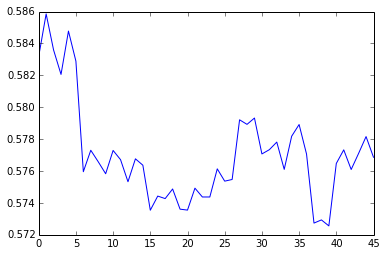

0 -1 27


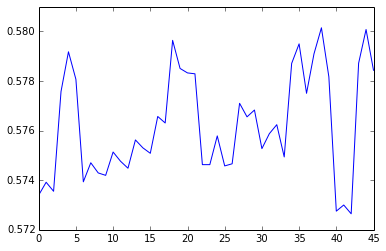

9 -1 28


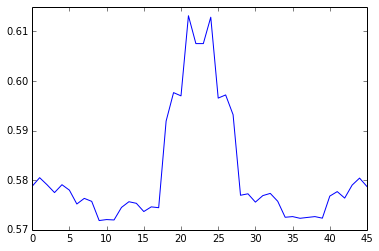

9 -1 29


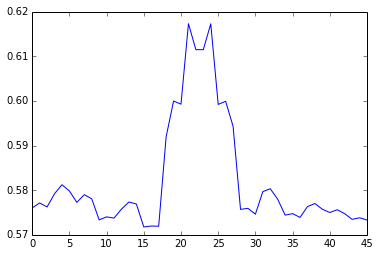

9 -1 30


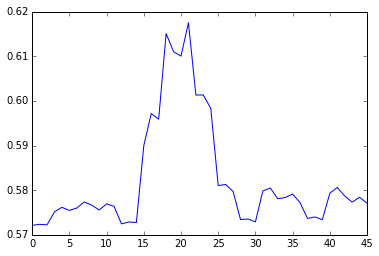

9 -1 31


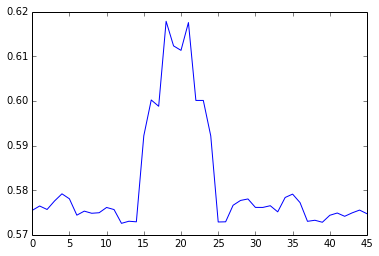

9 -1 32


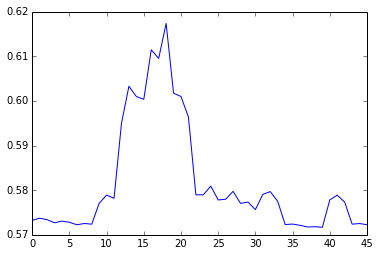

9 -1 33


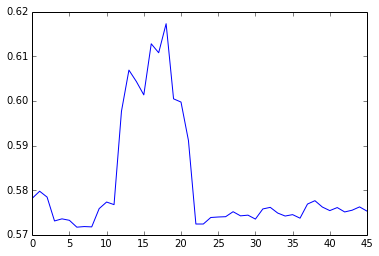

9 -1 34


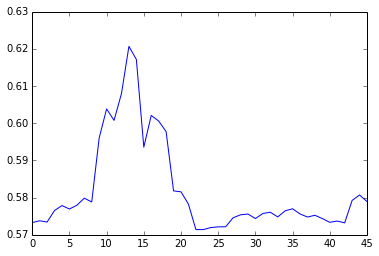

9 -1 35


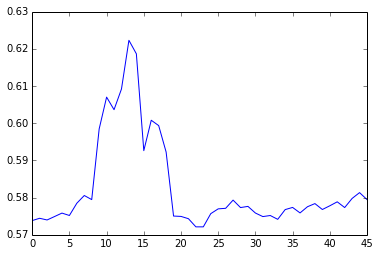

9 -1 36


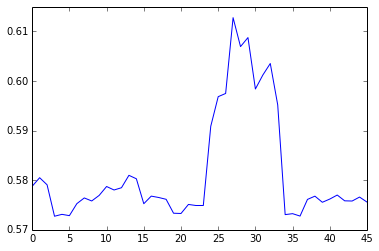

9 -1 37


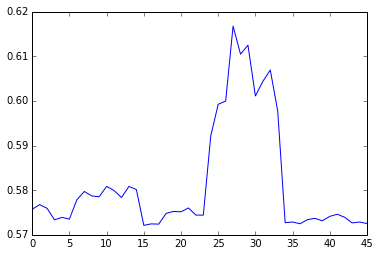

9 -1 38


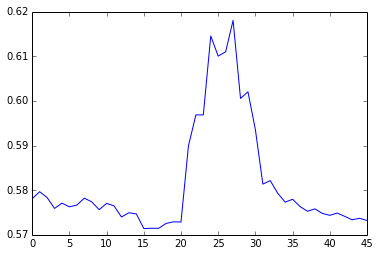

9 -1 39


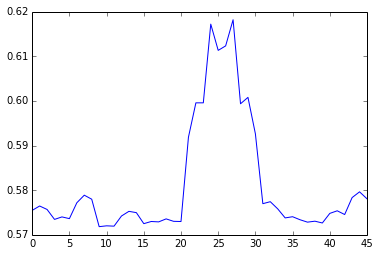

9 -1 40


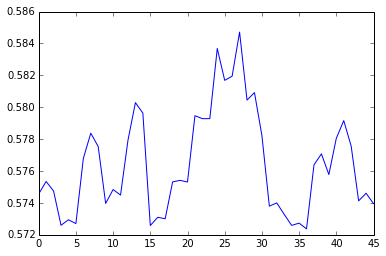

9 -1 41


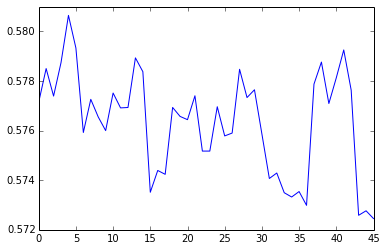

6 -1 42


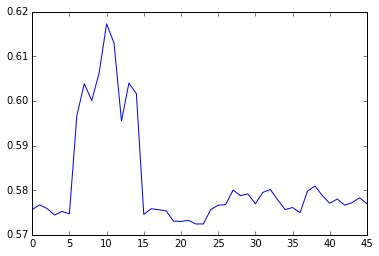

6 -1 43


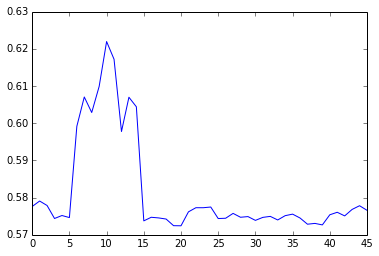

6 -1 44


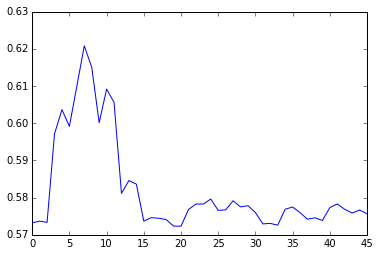

6 -1 45


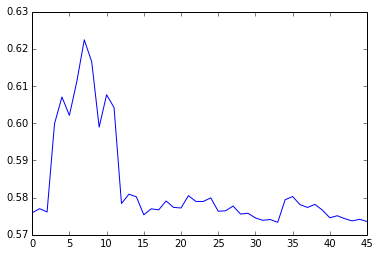

6 -1 46


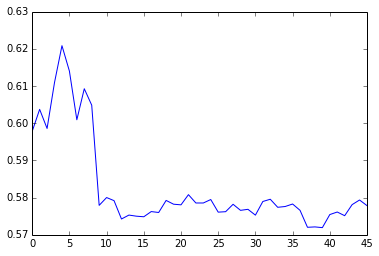

6 -1 47


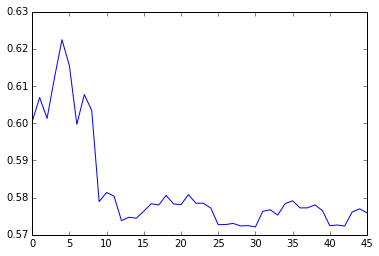

6 -1 48


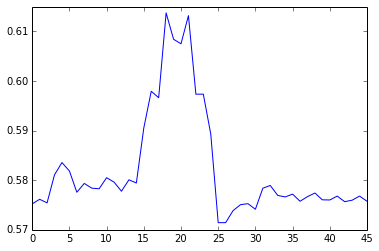

6 -1 49


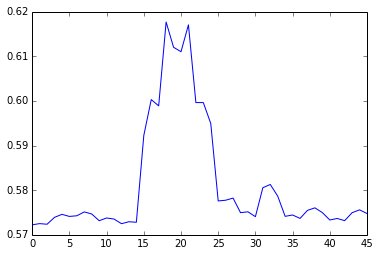

6 -1 50


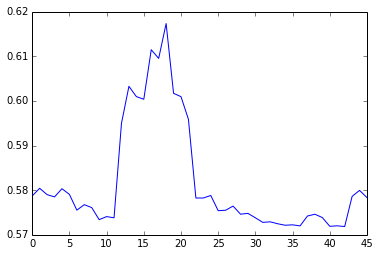

6 -1 51


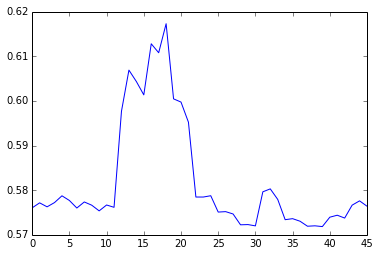

6 -1 52


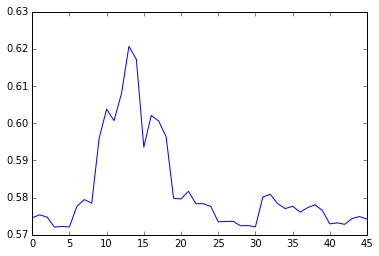

6 -1 53


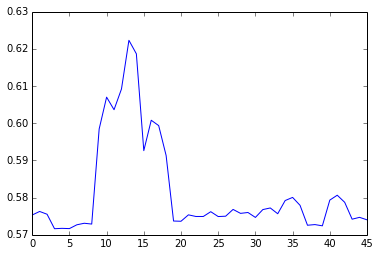

6 -1 54


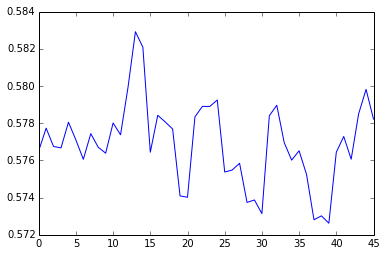

6 -1 55


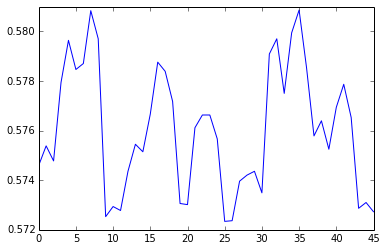

12 0 56


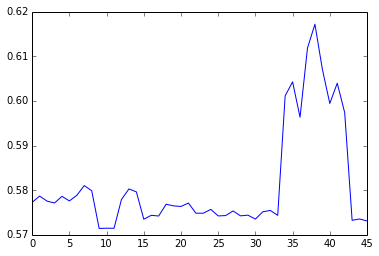

12 0 57


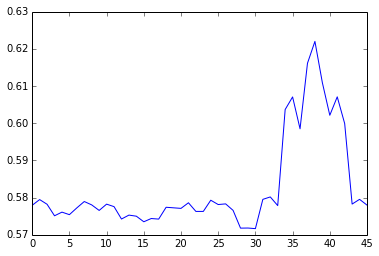

12 0 58


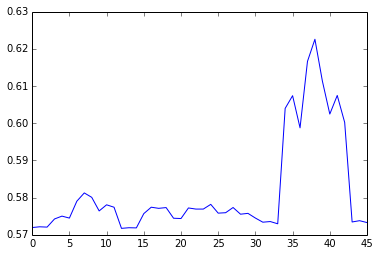

12 0 59


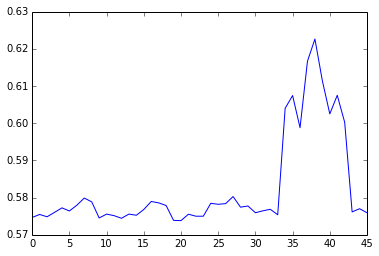

12 0 60


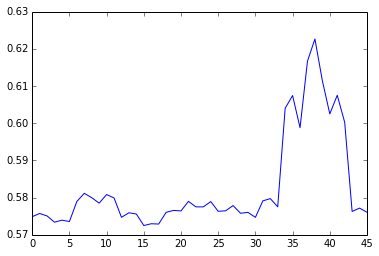

12 0 61


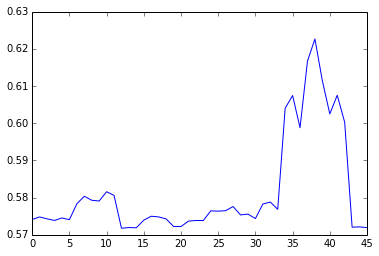

12 0 62


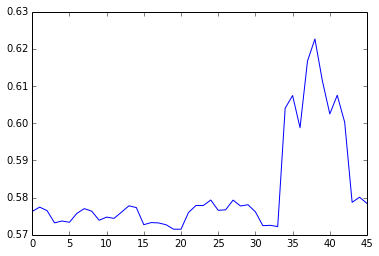

12 0 63


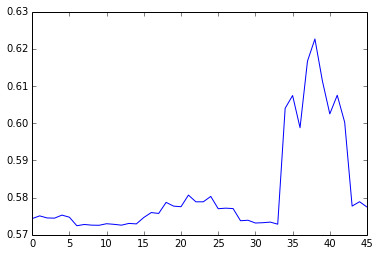

12 0 64


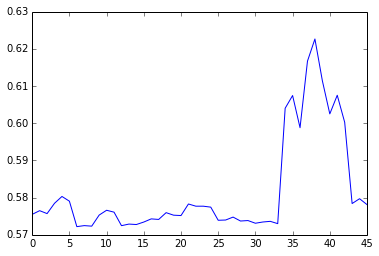

12 0 65


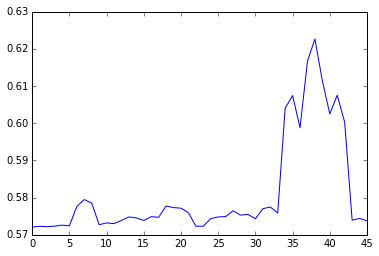

12 0 66


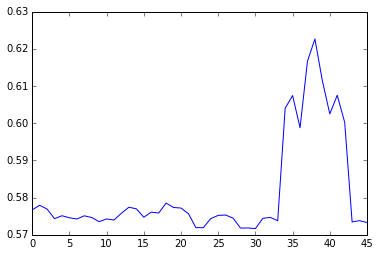

12 0 67


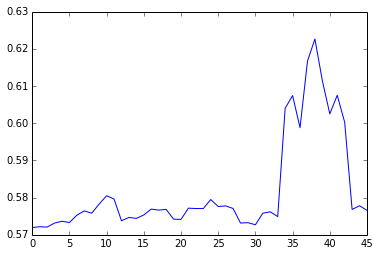

12 0 68


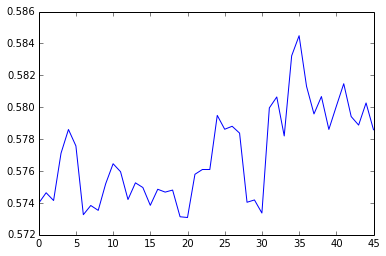

12 0 69


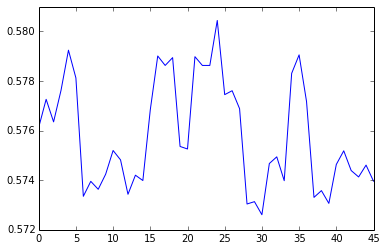

12 -1 70


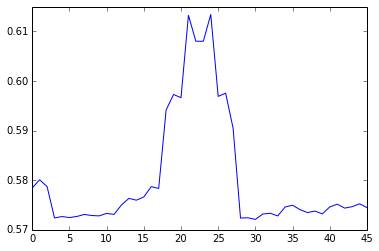

12 -1 71


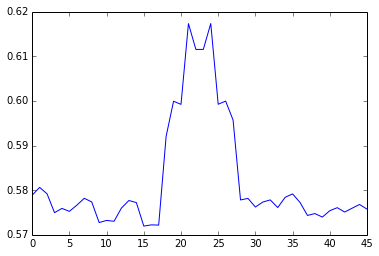

12 -1 72


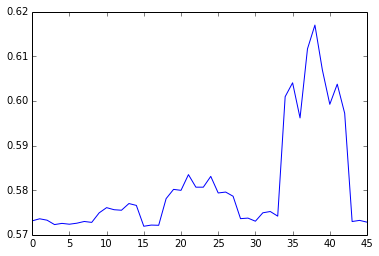

12 -1 73


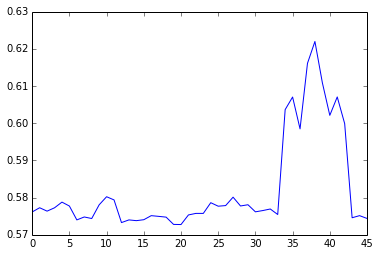

12 -1 74


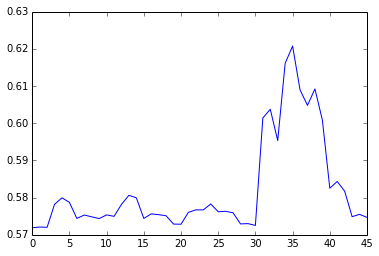

12 -1 75


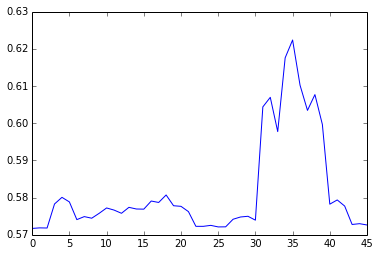

12 -1 76


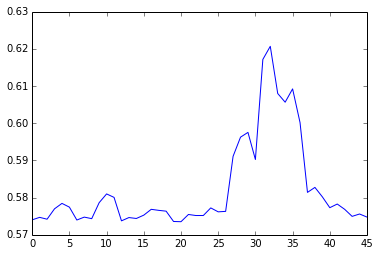

12 -1 77


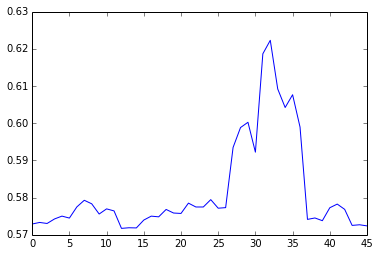

12 -1 78


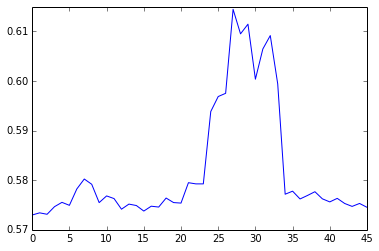

12 -1 79


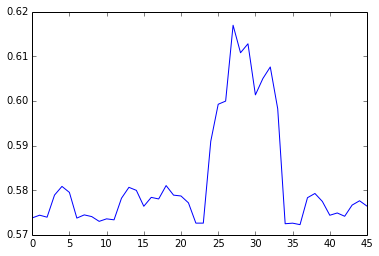

12 -1 80


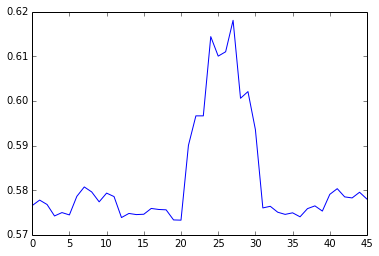

12 -1 81


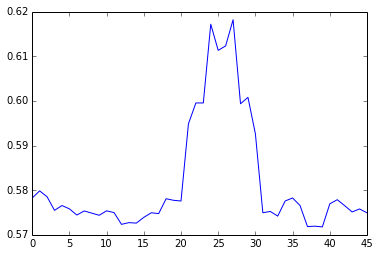

12 -1 82


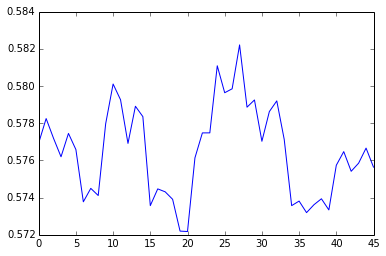

12 -1 83


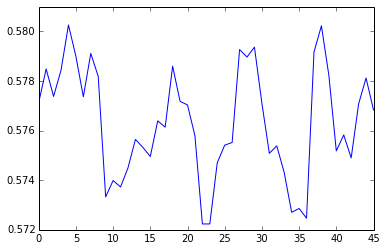

9 -1 84


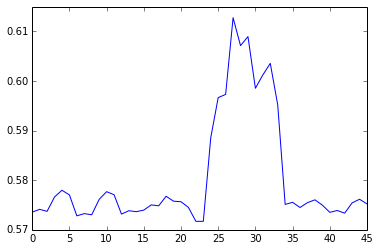

9 -1 85


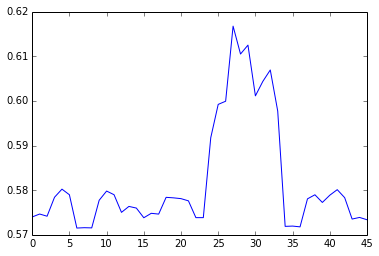

9 -1 86


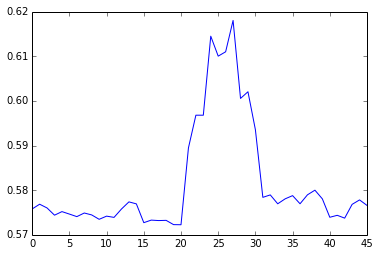

9 -1 87


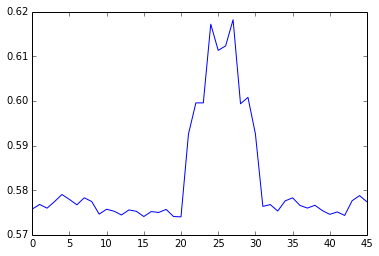

9 -1 88


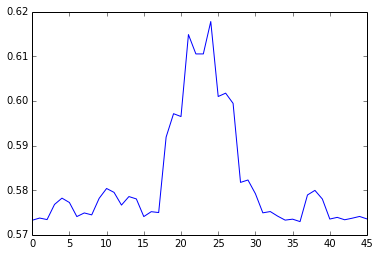

9 -1 89


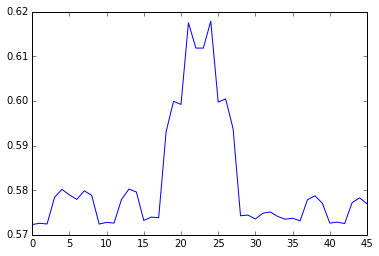

9 -1 90


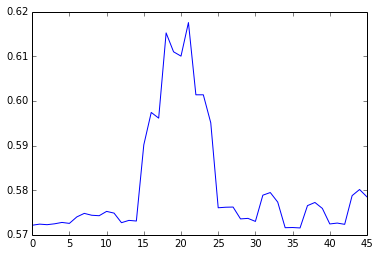

9 -1 91


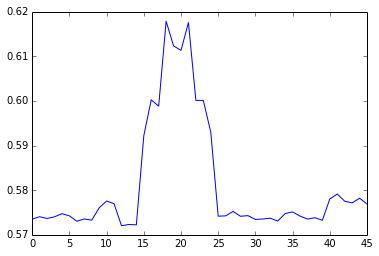

9 -1 92


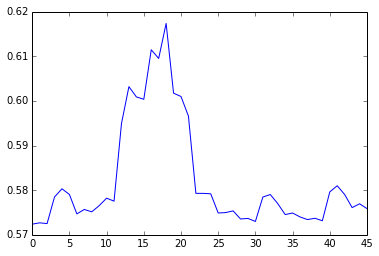

9 -1 93


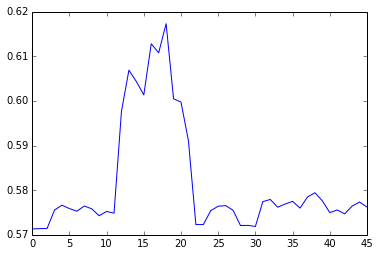

9 -1 94


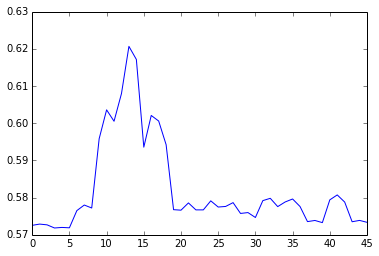

9 -1 95


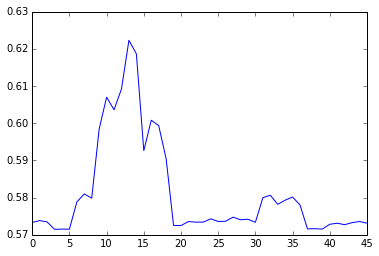

9 -1 96


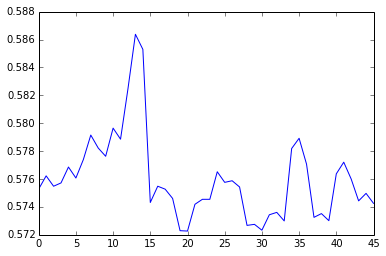

9 -1 97


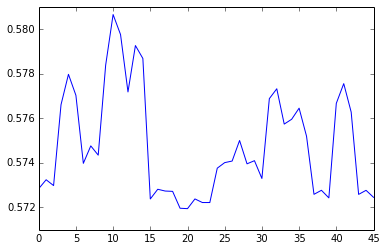

6 -1 98


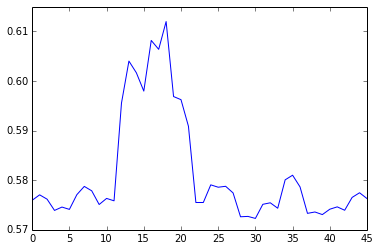

6 -1 99


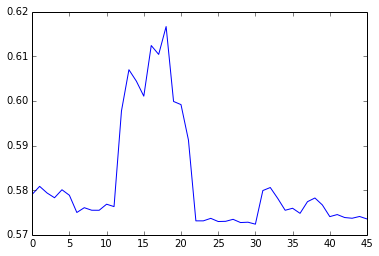

In [12]:
# Auditory simulation:
alpha = 0.5
LR=0.9
asd=0
X=np.zeros(neurons.shape)
for i in range(100):
    #X = np.random.rand(N[0],N[1])
    if i%14==0:
        F=np.random.choice(freqs)
        D = np.random.choice(dirs)
    print F, D, i
    inp = generateMovingFFT(F,i,D)
    
    X=alpha*(np.dot(c_inp.T,inp) + 0.2*np.dot(connections,X))+(1-1.2*alpha)*np.dot(np.identity(X.size),X)
    X=sigmoid(X,1)
    plt.plot(X)
    plt.show()